In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_parquet('E:/Phat/non-imbalance/data_processed.parquet')

Train, Test and Validation Split

In [4]:
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang',
    'ngay_hhluc_vitri_ddo',
    'ngay_hhluc_diemdo',
    'ngay_hhluc',
    'id_bcs',
    'ngay_kdinh',
    'loai_chiso',
    'ngay_hluc_diem_do',
    'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo',
    'ngay_hluc_khang',
    'gia_tri',
    'loai_giatri',
    'kimua_cspk',
    'id_ddo',
    'ma_dviqly',
    'so_cot',
    'so_hop',
    'ma_dvictren',
    'ky',
    'thang',
    'nam',
    'sluong_ttiep',
    'sluong_trphu',
    'thd_le',
    'ma_cnang_chiso',
    'ngay_bdong',
    'id_khang',
    'so_pha',
    'ngay_tao_chiso',
    'nguoi_tao_chiso',
    'ngay_sua_chiso',
    'nguoi_sua_chiso',
    'ngay_hluc'

]
target = 'fraud'

X = df.drop(columns=cols_to_drop)
y = df['fraud']


In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

[Text(0, 0.5, '4379498'), Text(0, 0.5, '56163')]

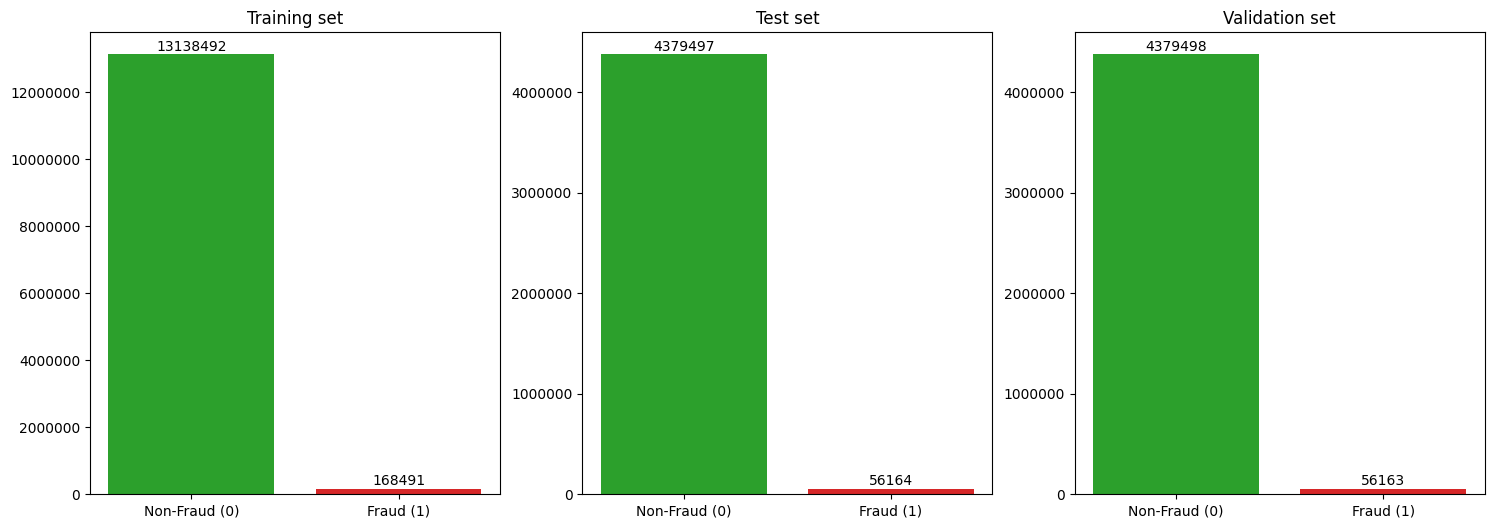

In [8]:
import matplotlib.pyplot as plt

# Tinh so luong  fraud va nonfraud trong 3 tap train, test va validation
non_fraud_train, fraud_train = y_train.value_counts()
non_fraud_test, fraud_test = y_test.value_counts()
non_fraud_valid, fraud_valid = y_val.value_counts()

# Ve bieu do bar chart the hien so luong fraud va non fraud
x = ['Non-Fraud (0)', 'Fraud (1)']
y1 = [non_fraud_train, fraud_train]
y2 = [non_fraud_test, fraud_test]
y3 = [non_fraud_valid, fraud_valid]
bar_color = ['tab:green','tab:red']

fig, axs = plt.subplots(1,3, figsize=(18,6))

bar1 = axs[0].bar(x, y1, color=bar_color)
axs[0].set_title('Training set')
axs[0].ticklabel_format(style='plain', axis='y')
axs[0].bar_label(bar1, padding= 0.5, fmt = '{:.0f}')

bar2 = axs[1].bar(x, y2, color=bar_color)
axs[1].set_title('Test set')
axs[1].ticklabel_format(style='plain', axis='y')
axs[1].bar_label(bar2, padding= 0.5, fmt = '{:.0f}')

bar3 = axs[2].bar(x, y3, color=bar_color)
axs[2].set_title('Validation set')
axs[2].ticklabel_format(style='plain', axis='y')
axs[2].bar_label(bar3, padding= 0.5, fmt = '{:.0f}')



Voting Ensemble

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tao custom metrix
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Tạo custom transformer để thực hiện oversampling và undersampling
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, oversampler, undersampler):
        self.oversampler = oversampler
        self.undersampler = undersampler

    def fit(self, X, y):
        # Không cần fit gì ở đây, chỉ cần trả về chính X, y
        return self

    def transform(self, X, y=None):
        # Áp dụng oversampling rồi đến undersampling nếu y không phải None
        if y is not None:
            X_res, y_res = self.oversampler.fit_resample(X, y)
            X_res, y_res = self.undersampler.fit_resample(X_res, y_res)
            return X_res, y_res
        return X  # Nếu y là None, chỉ trả về X


In [11]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
import xgboost as xgb 
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

SEED = 42

cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24,
    # 'cat_features':      cat_cols,
}

lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     SEED,
    'lambda_l1':        0.08758718919397321,
    'lambda_l2':        0.0039689175176025465,
    'learning_rate':    0.03231007103195577,
    'max_depth':        4,
    'num_leaves':       103,
    'colsample_bytree': 0.8329551585827726,
    'colsample_bynode': 0.4025961355653304,
    'bagging_fraction': 0.7738954452473223,
    'bagging_freq':     4,
    'min_data_in_leaf': 85,
    'scale_pos_weight': 2.7984184778875543,
    # 'device': 'gpu'
}

xgb_params = {
    # 'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       SEED,
    'learning_rate':      0.08501257473292347,
    'lambda':             8.879624125465703,
    'alpha':              0.6779926606782505,
    'max_depth':          6,
    'subsample':          0.6012681388711075,
    'colsample_bytree':   0.8437772277074493,
    'colsample_bylevel':  0.5476090898823716,
    'colsample_bynode':   0.9928601203635129,
    'scale_pos_weight':   3.29440313334688,
}


X = X_temp
y= y_temp

# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

#Ensemble of models
estimator = [
    ('CB', CatBoostClassifier(**cb_params)),
    ('DT', DecisionTreeClassifier(
            criterion='gini',        # Hoặc 'entropy'
            max_depth=6,             # Giới hạn độ sâu của cây
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=SEED)),
    ('LGBM', lgbm.LGBMClassifier(**lgb_params)),
    ('XGB', xgb.XGBClassifier(**xgb_params))
]

# Khởi tạo mô hình VotingClassifier
model = VotingClassifier(estimators= estimator, voting='soft')

# Khởi tạo các phương pháp resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

# Tạo pipeline hoàn chỉnh sử dụng custom transformer
full_pipeline = Pipeline([
    ('resample', ResampleTransformer(oversampler, undersampler)),
    ('model', model)
])

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
full_pipeline.fit(X, y)



Performing cross-validation with Augmentation...
Cross-validation pAUC scores: [0.19756487 0.19764703 0.19762491 0.19759097 0.19758975]
Mean pAUC: 0.1976, Std: 0.0000
Training final model on the entire combined dataset...


Pipeline(steps=[('resample',
                 ResampleTransformer(oversampler=RandomOverSampler(random_state=42,
                                                                   sampling_strategy=0.03),
                                     undersampler=RandomUnderSampler(random_state=42,
                                                                     sampling_strategy=0.03))),
                ('model',
                 VotingClassifier(estimators=[('CB',
                                               <catboost.core.CatBoostClassifier object at 0x00000185FADE0560>),
                                              ('DT',
                                               DecisionTreeClassifier(max_depth=6,
                                                                      min_samples...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             lambda=8.879624125465703,
                                                             learning_rate=0.08501257473292347,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None, ...))],
                                  voting='soft'))])

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   4379497
           1       0.66      0.54      0.60     56164

    accuracy                           0.99   4435661
   macro avg       0.83      0.77      0.80   4435661
weighted avg       0.99      0.99      0.99   4435661



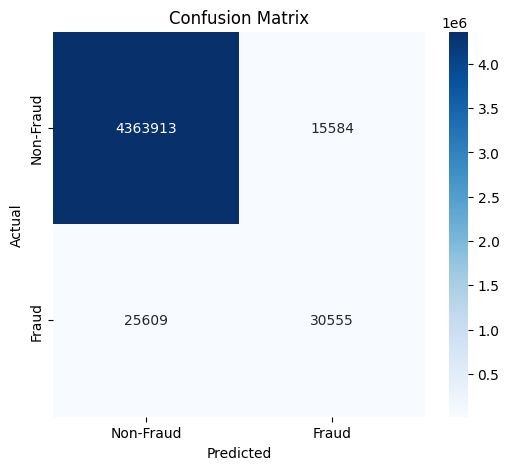

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
X_test = X_test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

Custom pAUC Score: 0.1976815765156278
AUC Score: 0.9957341928650149


Text(0, 0.5, 'True Positive Rate')

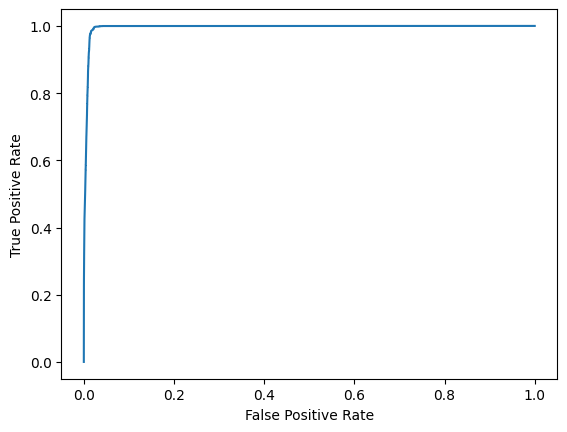

In [15]:
# Ve ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')